In [2]:
#@title Setup and Imports (run this first)
import torch 
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import IPython.display as ipd

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.models import vgg16
from tqdm.notebook import tqdm

from CLIP import clip # The clip model
from torchvision import transforms # Some useful image transforms
import torch.nn.functional as F # Some extra methods we might need
from tqdm.notebook import tqdm # A progress bar library

# VQGAN

In [4]:
print("Downloading CLIP and installing requirements")
!git clone https://github.com/openai/CLIP                 &> /dev/null
!pip install -q  ftfy regex tqdm omegaconf pytorch-lightning &> /dev/null

# Downloading the pre-trained VQGAN model weights:
print('Downloading ImageNet 16384 checkpoints')
!curl -L 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' > vqgan_imagenet_f16_16384.yaml
!curl -L 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' > vqgan_imagenet_f16_16384.ckpt

# I like to save the weights to my drive so that I can do this instead:
# !cp 'drive/My Drive/vqgan_imagenet_f16_16384.yaml' vqgan_imagenet_f16_16384.yaml
# !cp 'drive/My Drive/vqgan_imagenet_f16_16384.ckpt' vqgan_imagenet_f16_16384.ckpt

print('Installing a few libraries')
!git clone https://github.com/CompVis/taming-transformers &> /dev/null
!pip install einops                                       &> /dev/null

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   692  100   692    0     0    733      0 --:--:-- --:--:-- --:--:--   733
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  934M  100  934M    0     0  9339k      0  0:01:42  0:01:42 --:--:-- 8372k
Installing a few libraries


In [3]:
# @title some setup and convenience functions
from omegaconf import OmegaConf
import sys
sys.path.append('./taming-transformers')
from taming.models import cond_transformer, vqgan

def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model

class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
 
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
 
 
replace_grad = ReplaceGrad.apply
 
 
class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)
 
    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None
 
 
clamp_with_grad = ClampWithGrad.apply

def vector_quantize(x, codebook):
  d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
  indices = d.argmin(-1)
  x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
  return replace_grad(x_q, x)

def synth(z):
  z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
  return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

def rand_z(width, height):
  f = 2**(model.decoder.num_resolutions - 1)
  toksX, toksY = width // f, height // f
  n_toks = model.quantize.n_e
  one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
  z = one_hot @ model.quantize.embedding.weight
  z = z.view([-1, toksY, toksX, model.quantize.e_dim]).permute(0, 3, 1, 2)
  return z

normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],std=[0.26862954, 0.26130258, 0.27577711])
similarity = torch.nn.CosineSimilarity()

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = load_vqgan_model('vqgan_imagenet_f16_16384.yaml', 'vqgan_imagenet_f16_16384.ckpt').to(device)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt


In [5]:
# Load in one of the models from CLIP
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
local_clip_path = '/home/chenweifeng/open_clip/src/logs/2022_06_01-18_24_45-model_ViT-B-32-lr_0.0005-b_640-j_8-p_amp/checkpoints/epoch_18.pt'
import open_clip

# perceptor = clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device)
# perceptor = open_clip.create_model_and_transforms(local_clip_path, jit=False)[0].eval().requires_grad_(False).to(device)
perceptor, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained=local_clip_path)
perceptor = perceptor.eval().requires_grad_(False).to(device)
# print(perceptor.visual.input_resolution) # 224px a side

torch.Size([1, 256, 16, 8])


  0%|          | 0/1000 [00:00<?, ?it/s]

0 0.7845455408096313
100 0.6872357130050659
200 0.6927803754806519
300 0.67462158203125
400 0.6469414234161377
500 0.642725944519043
600 0.6449559926986694
700 0.6648749113082886
800 0.6647368669509888
900 0.6587058305740356


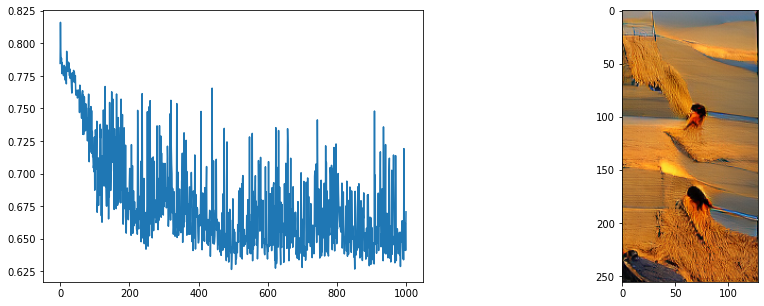

In [15]:
# Some text target
text_embed = perceptor.encode_text(clip.tokenize("夕阳沙滩").to(device)).float()

# Starting z for image size 128x128
z = rand_z(128, 256) 
print(z.shape)
z.requires_grad=True

# A transform to map the generated image to the size expected by CLIP
crop = transforms.RandomResizedCrop(224)

# The optimizer - feel free to try different ones here
optimizer = torch.optim.Adam([z], lr=0.1, weight_decay=1e-6)

losses = [] # Keep track of our losses (RMSE values)

for i in tqdm(range(1000)):

  # Reset everything related to gradient calculations
  optimizer.zero_grad()

  # Get the GAN output
  output = synth(z) # z: 1,256,16,16 --> output: 1,3,256,256

  # Calculate our loss 余弦相似度，直接对GAN输出的图像进行编码。
  image_embed = perceptor.encode_image(crop(normalize(output)).to(device)).float()
  loss = 1 - similarity(image_embed, text_embed) # torch.mean(output) #clip_loss(output, text_embed)

  # Store the loss for later
  if i % 100 == 0:
    print(i, loss.detach().item())
  losses.append(loss.detach().item())

  # Backpropagate the loss and use it to update the parameters
  loss.backward() # This does all the gradient calculations
  optimizer.step() # The optimizer does the update

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(losses)
axs[1].imshow(synth(z).cpu().squeeze().detach().permute(1, 2, 0))

In [6]:
def clip_loss(im_embed, text_embed):
  im_normed = F.normalize(im_embed.unsqueeze(1), dim=2)
  text_normed = F.normalize(text_embed.unsqueeze(0), dim=2)
  dists = im_normed.sub(text_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2) # Squared Great Circle Distance
  
  # dists = 1 - similarity(im_normed, text_normed)  # NOTE cosine distance 
  return dists.mean()


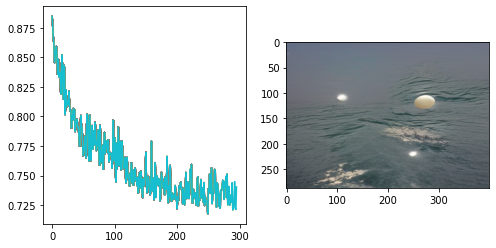

In [7]:
prompt_text = "海上生明月" #@param
width = 400 #@param
height = 300 #@param
lr = 0.1 #@param
n_iter = 300 #@param
crops_per_iteration = 8 #@param

# The transforms to get variations of our image
tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomAffine(5),
    transforms.ColorJitter(),
    transforms.GaussianBlur(5),
])

# The z we'll be optimizing
z = rand_z(width, height)
z.requires_grad=True


# The text target
text_embed = perceptor.encode_text(clip.tokenize(prompt_text).to(device)).float()

# The optimizer - feel free to try different ones here
optimizer = torch.optim.Adam([z], lr=lr, weight_decay=1e-6)

losses = [] # Keep track of our losses (RMSE values)

# A folder to save results
!rm -r steps
!mkdir steps

# Display for showing progress
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
p = display(fig, display_id=True)

# The optimization loop:
for i in tqdm(range(n_iter)):

  # Reset everything related to gradient calculations
  optimizer.zero_grad()

  # Get the GAN output
  output = synth(z)

  # Calculate our loss across several different random crops/transforms
  loss = 0
  for _ in range(crops_per_iteration):
    # NOTE 这里同时计算多张随机数据增强的图像的结果loss，用均值的loss来引导生成的方向。
    image_embed = perceptor.encode_image(tfms(normalize(output)).to(device)).float()
    loss += clip_loss(image_embed, text_embed)/crops_per_iteration

  # Store loss
  losses.append(loss.detach().item())

  # Save image
  im_arr = np.array(output.cpu().squeeze().detach().permute(1, 2, 0)*255).astype(np.uint8)
  Image.fromarray(im_arr).save(f'steps/{i:04}.jpeg')

  # Update plots 
  if i % 5 == 0: # Saving time
    axs[0].plot(losses)
    axs[1].imshow(im_arr)
    p.update(fig)

  # Backpropagate the loss and use it to update the parameters
  loss.backward() # This does all the gradient calculations
  optimizer.step() # The optimizer does the update

ipd.clear_output()